## Performing Exploratory Data Analysis for Student Retention

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.stats as stats

from tools.utils import combine_columns, compute_feature_importance

In [3]:
# Load in cleaned data
data = pd.read_csv("data/Most-Recent-Cohorts-Institution-filtered.csv")
data = data.drop('Unnamed: 0', axis=1)

In [4]:
four_yr_retention = data.RET_FT4
less_four_yr_retention = data.RET_FTL4

## Many Null Values

Pre-emptively lets look at the null values for each of the variables we will be focusing on. 

Student retention, the dependent variables in our analaysis, are red.

In [5]:
nulls_by_column = data.isna().sum().sort_values(ascending=False)

In [9]:
colors = np.tile('b', len(nulls_by_column))

retention = ["RET_FT4", "RET_FTL4"]
retention_vars_mask = pd.Series(nulls_by_column.index).isin(retention).values
colors[retention_vars_mask] = np.tile('r', len(retention))

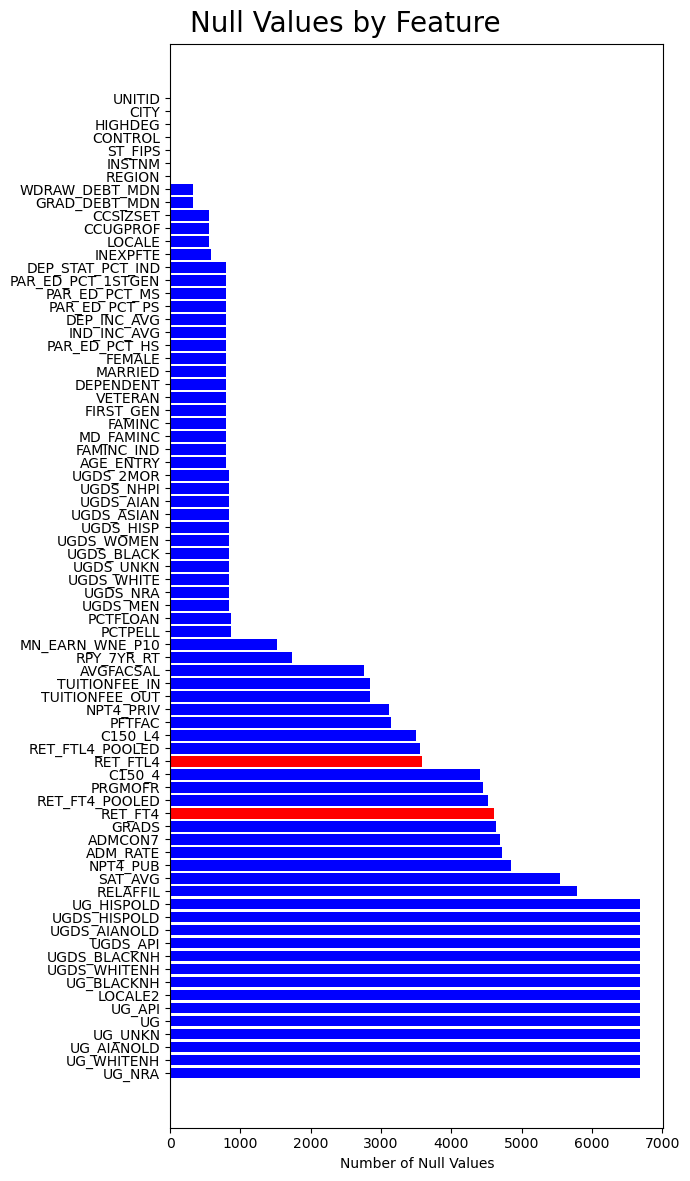

In [10]:
fig, ax = plt.subplots(figsize=(7, 12))
ax.barh(np.arange(-5, len(nulls_by_column)-5), nulls_by_column.values, color=colors)
ax.set_yticks(np.arange(-5, len(nulls_by_column)-5), labels=nulls_by_column.index)
ax.set_xlabel("Number of Null Values")
fig.suptitle("Null Values by Feature", size=20)
fig.tight_layout();

We will be dealing with a high amount of null values, especially when looking at the number of programs. In fact, the last several columns listed are entirely null.

# Does number of programs offered (PRGMOFR) affect retention?

Notice that of the institutions with data, a large proportion offer only a few programs. Upon close inspection, these appear to be highly specialized trade schools

In [426]:
edu.PRGMOFR.value_counts()[:10]

1.0     379
2.0     352
3.0     342
4.0     309
5.0     214
6.0     156
7.0     105
9.0      72
8.0      60
10.0     43
Name: PRGMOFR, dtype: int64

Take "New Beginning College of **Cosmetology**" or "Elite **Welding** Academy South Point", for example

In [427]:
edu[edu.PRGMOFR<=10].INSTNM

17         New Beginning College of Cosmetology
60           Alaska Vocational Technical Center
62                        Alaska Career College
63                  Empire Beauty School-Tucson
64             Carrington College-Phoenix North
                         ...                   
6116     San Joaquin Valley College-Porterville
6118                  Ruben's Five Star Academy
6123         Miller-Motte College-Chattanooga 2
6125          Elite Welding Academy South Point
6126    Zorganics Institute Beauty and Wellness
Name: INSTNM, Length: 2032, dtype: object

Note that ```UNITID``` is the pkey, and that 98 Institutions of the same name are connected to multiple ```UNITID```'s

In [428]:
print("UNITID is the primary key: ", len(edu) == len(edu.groupby("UNITID")))
print("INSTNM is the primary key: ", len(edu) == len(edu.groupby("INSTNM")))

UNITID is the primary key:  True
INSTNM is the primary key:  False


We hypothesize that institutions with thh same name ```INSTNM``` are actually the same parent institution with sub-institutions denoted by different ```UNITID```'s.

This would mean that the number of programs offered is undercounted, and we should sum the number of programs offered for each 'parent institution'.

Let us informally explore this hypothesis.

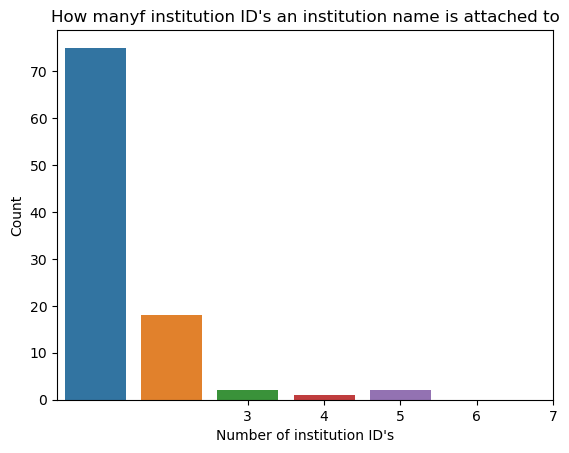

In [429]:
#find the number of schools by the same name
duplicates_by_instnm = edu.groupby("INSTNM").UNITID.count().sort_values(ascending=False)
duplicates = num_duplicates[num_duplicates>1]
counts = duplicates.value_counts().sort_index()

# bar plot of how many institution ID's a name is attached to
ax = plt.subplot()
sns.barplot(x=counts.index, y=counts)
ax.set_title("How manyf institution ID's an institution name is attached to")
ax.set_ylabel("Count")
ax.set_xlabel("Number of institution ID's")
ax.set_xticks(np.arange(2, 7, dtype=int))
ax.set_xticklabels(duplicates.value_counts().sort_index().index.values+1)
ax.grid(False);


Most institutions are only connected to one institution ID and name, but there are enough names connected to multiple institutions that they could represent a different relationship with student retention. 

Let's explore ```PRGMOFR```'s institutions with 'duplicate' rows (one for each sub-institution) separately from ```PRFMOFR``` as a whole.

In [430]:
#aggregate information on institution by each name
inst_per_instnm = edu.groupby("INSTNM")[["UNITID", "PRGMOFR", "CITY"]]\
    .agg([list, len]).sort_values([("CITY", "len")], ascending=False)\
    .drop(columns=[(col, "len") for col in ["UNITID", "PRGMOFR"]])
inst_per_instnm.head()

UNITID  \
                                                                      list   
INSTNM                                                                       
Jersey College           [455196, 45519601, 45519602, 45519603, 4551960...   
Cortiva Institute         [128896, 134574, 215044, 387925, 434308, 438285]   
Columbia College                  [112561, 177065, 217934, 455983, 479248]   
Arthur's Beauty College                   [106360, 106494, 445540, 489830]   
Unitek College                          [459204, 476799, 479424, 45920401]   

                                                PRGMOFR  \
                                                   list   
INSTNM                                                    
Jersey College           [9.0, nan, nan, nan, nan, nan]   
Cortiva Institute        [1.0, 3.0, 1.0, 4.0, 2.0, 4.0]   
Columbia College              [nan, nan, nan, 8.0, 4.0]   
Arthur's Beauty College            [2.0, 2.0, 2.0, 2.0]   
Unitek College                     [nan, 2.0, 2.0, nan]   

                                                                      CITY      
                                                                      list len  
INSTNM                                                                          
Jersey College           [Teterboro, Tampa, Ewing, Jacksonville, Sunris...   6  
Cortiva Institute        [Cromwell, St. Petersburg, King of Prussia, Po...   6  
Columbia College         [Sonora, Columbia, Columbia, Vienna, Centreville]   5  
Arthur's Beauty College      [Fort Smith, Jacksonville, Conway, Jonesboro]   4  
Unitek College            [Fremont, South San Francisco, Hayward, Fremont]   4

As a sanity check, let's look at Unitek college. From a google search, it is in fact the same Univrsity with multiple campuses. 

We cannot manually verify this for all of the institutions in the dataset, so let us first see if this analysis is worth pursuing by examining the correlation with student retention rate.

In [431]:
#sum the PRGMOFR values for each institution name, treating np.nan's as 0
PRGMOFR_with_dups = inst_per_instnm[[("PRGMOFR", "list")]].apply(lambda x: np.nansum(x.values[0]), axis=1)
PRGMOFR_dups_sample = edu[edu.INSTNM.isin(PRGMOFR_with_dups.index.values)]

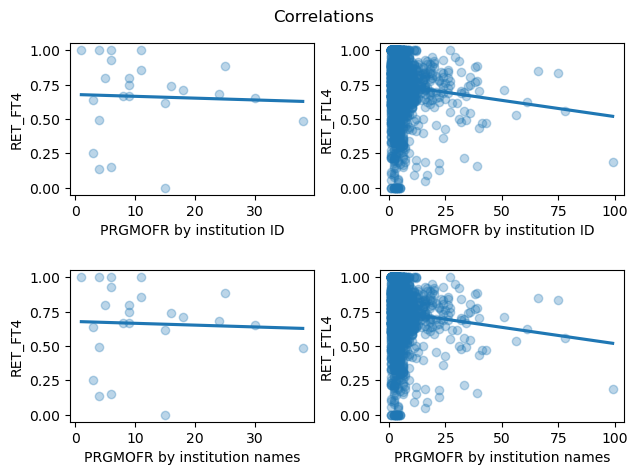

In [432]:
fig, axs = plt.subplots(2, 2)
sns.regplot(x = "PRGMOFR", y = "RET_FT4", data = PRGMOFR_dups_sample, scatter_kws={'alpha':0.3}, ci=False, ax=axs[0,0])
axs[0,0].set_xlabel("PRGMOFR by institution ID")
pos = axs[0,0].get_position()
pos.y0 += .4
axs[0,0].set_position(pos)
sns.regplot(x = "PRGMOFR", y = "RET_FTL4", data = PRGMOFR_dups_sample, scatter_kws={'alpha':0.3}, ci=False, ax=axs[0,1])
axs[0,1].set_xlabel("PRGMOFR by institution ID")
pos = axs[0,1].get_position()
pos.y0 += .4
axs[0,1].set_position(pos)
sns.regplot(x = "PRGMOFR", y = "RET_FT4", data = edu, scatter_kws={'alpha':0.3}, ci=False, ax=axs[1,0])
axs[1,0].set_xlabel("PRGMOFR by institution names")
sns.regplot(x = "PRGMOFR", y = "RET_FTL4", data = edu, scatter_kws={'alpha':0.3}, ci=False, ax=axs[1,1])
axs[1,1].set_xlabel("PRGMOFR by institution names")
fig.tight_layout()
fig.subplots_adjust(hspace=.5)
fig.suptitle("Correlations");

Looking at the scatterplots, the relationships are roughly linear, and the correlations between retention rate at 4-years ```RET_FT4```, at less-than-4-years ```RET_FTL4```, and the number of programs by institution and by the name of potentially parent institutions are extermely weak therefore we will not pursue this variable further.

It shuold be noted that if there are parent institutions with many sub-institutions' ID's ```UNITID```, that parent institution may not have all its sub-institutions labeled with the same name ```INSTNM```. Furthremore, institutions could have the same name by conincedence and not be related. If further information on parent-institutinos becomes available, we can pursue this idea again. 

Furthermore, a large proportion of ```PRGMOFR``` is null, meaning that our analysis on the non-nulls may not be representative of the sample and therefore of the population.

Therefore, ```PRGMOFR``` cannot be proven to be significantly associated with student retention features ```RET_FT4``` and ```RET_FTL4```

# Analyze how parent education affects retention of students 

```PAR_ED_PCT_MS``` is the percentage of parents who have a middle school education

```PAR_ED_PCT_HS``` is the percentage of parents who have a high school education

```PAR_ED_PCT_PS``` is the percentage of parents who have some college school education

Only about 10% of these columns' values are null, so we can trust our analysis of these variables with greater certainty.

However, note that the null values occur for exactly the same rows, meaning that they likely share some trait or may come from a different generating distribution. We will drop these values for now as they represent a minority of the dataset

In [433]:
prop_null = edu.PAR_ED_PCT_MS.isna().sum() / len(edu.PAR_ED_PCT_MS)
null_MS = edu.PAR_ED_PCT_MS.isna().sum()
null_HS = edu.PAR_ED_PCT_HS.isna().sum()
null_PS = edu.PAR_ED_PCT_PS.isna().sum()
print("prop null: ", prop_null)

#each column has the same number of nulls.
print("number of nulls for MS, HS, college (PS) respectively: ", null_MS, null_HS, null_PS)

prop null:  0.11824577159107919
number of nulls for MS, HS, college (PS) respectively:  790 790 790


In [434]:
#each column has nulls in the exact same row as the other columns
edu[["PAR_ED_PCT_MS", "PAR_ED_PCT_HS", "PAR_ED_PCT_PS"]].isna().apply(all, axis=1).sum()

790

There are also "PrivacySuppressed" values which act as null values. They still represent a minority of the dataset so we will continue our analysis. 

Note that once again these null-like values contain a pattern. Rows which are "PrivacySuppressed" for college education ```PAR_ED_PCT_PS``` tend to be privacy suppressed in highschool education ```PAR_ED_PCT_HS``` and middle school education ```PAR_ED_PCT_PS```. Similarly, rows which are "PrivacySuppressed" for highschool education ```PAR_ED_PCT_HS``` tend to be privacy suppressed in middleschool education ```PAR_ED_PCT_MS```. 

This may have something to do with higschool requiring  amiddleschool education, and college requiring a highschool education. It may also have something to do with the school's size, as having a smaller population makes it easier to re-identify individuals from aggregate data. 

These two questions are out of the scope of our project. If school size is a confounding factor, our meta-analysis of feature importance will include those confounders, adjusting for them. 

For now we will drop the null values and PrivacySuppressed values to continue our analysis.

In [435]:
prop_PS_MS = edu.PAR_ED_PCT_MS.str.match("PrivacySuppressed").sum() / len(edu.PAR_ED_PCT_MS)
prop_PS_HS = edu.PAR_ED_PCT_HS.str.match("PrivacySuppressed").sum() / len(edu.PAR_ED_PCT_MS)
prop_PS_PS = edu.PAR_ED_PCT_PS.str.match("PrivacySuppressed").sum() / len(edu.PAR_ED_PCT_MS)
PS_MS = edu.PAR_ED_PCT_MS.str.match("PrivacySuppressed").sum()
PS_HS = edu.PAR_ED_PCT_HS.str.match("PrivacySuppressed").sum()
PS_PS = edu.PAR_ED_PCT_PS.str.match("PrivacySuppressed").sum()
print("prop of PrivacySuppressed for MS, HS, college (PS) respectively: ", prop_PS_MS, prop_PS_HS, prop_PS_PS)
print("number of PrivacySuppressed for MS, HS, college (PS) respectively: ", PS_MS, PS_HS, PS_PS)

prop of PrivacySuppressed for MS, HS, college (PS) respectively:  0.2972608890884598 0.2962131417452477 0.11465349498578058
number of PrivacySuppressed for MS, HS, college (PS) respectively:  1986 1979 766


In [436]:
# 757 of the college-education column's 766 PrivacySuppressed values are also PrivacySuppressed in the HS and MS education columns 
edu[["PAR_ED_PCT_MS", "PAR_ED_PCT_HS", "PAR_ED_PCT_PS"]].astype(str).\
    apply(lambda col: col.str.match("PrivacySuppressed"), axis=0).\
    apply(all, axis=1).sum()

757

In [437]:
# 1978 of the HS-education column's 1979 PrivacySuppressed values are also PrivacySuppressed in the MS education columns
edu[["PAR_ED_PCT_MS", "PAR_ED_PCT_HS"]].astype(str).\
    apply(lambda col: col.str.match("PrivacySuppressed"), axis=0).\
    apply(all, axis=1).sum()

1978

We can't analyze the same exact subsample when measuring association with ```RET_FT4``` and ```RET_FTL4``` because one or the other is always null.

In [448]:
(~edu[["RET_FT4", "RET_FTL4"]].isna().apply(any, axis=1)).sum()

0

Therefore we will measure association on different samples for ```RET_FT4``` and ```RETFTL4```.

In [454]:
#select all rows with "PrivacySuppressed" in them
edu_all_PrivacySuppressed_indices = edu[["PAR_ED_PCT_MS", "PAR_ED_PCT_HS", "PAR_ED_PCT_PS"]].\
    apply(lambda col: col.astype(str).str.match("PrivacySuppressed")).\
    apply(any, axis=1)

#remove those rows
edu_no_PrivacySuppressed_ft4 = edu[~edu_all_PrivacySuppressed_indices]\
    [["PAR_ED_PCT_MS", "PAR_ED_PCT_HS", "PAR_ED_PCT_PS", "RET_FT4"]].\
    dropna().\
    astype(float)

edu_no_PrivacySuppressed_ftl4 = edu[~edu_all_PrivacySuppressed_indices]\
    [["PAR_ED_PCT_MS", "PAR_ED_PCT_HS", "PAR_ED_PCT_PS", "RET_FTL4"]].\
    dropna().\
        astype(float)

#check to see how large our subsample is
len(edu_no_PrivacySuppressed)

1410

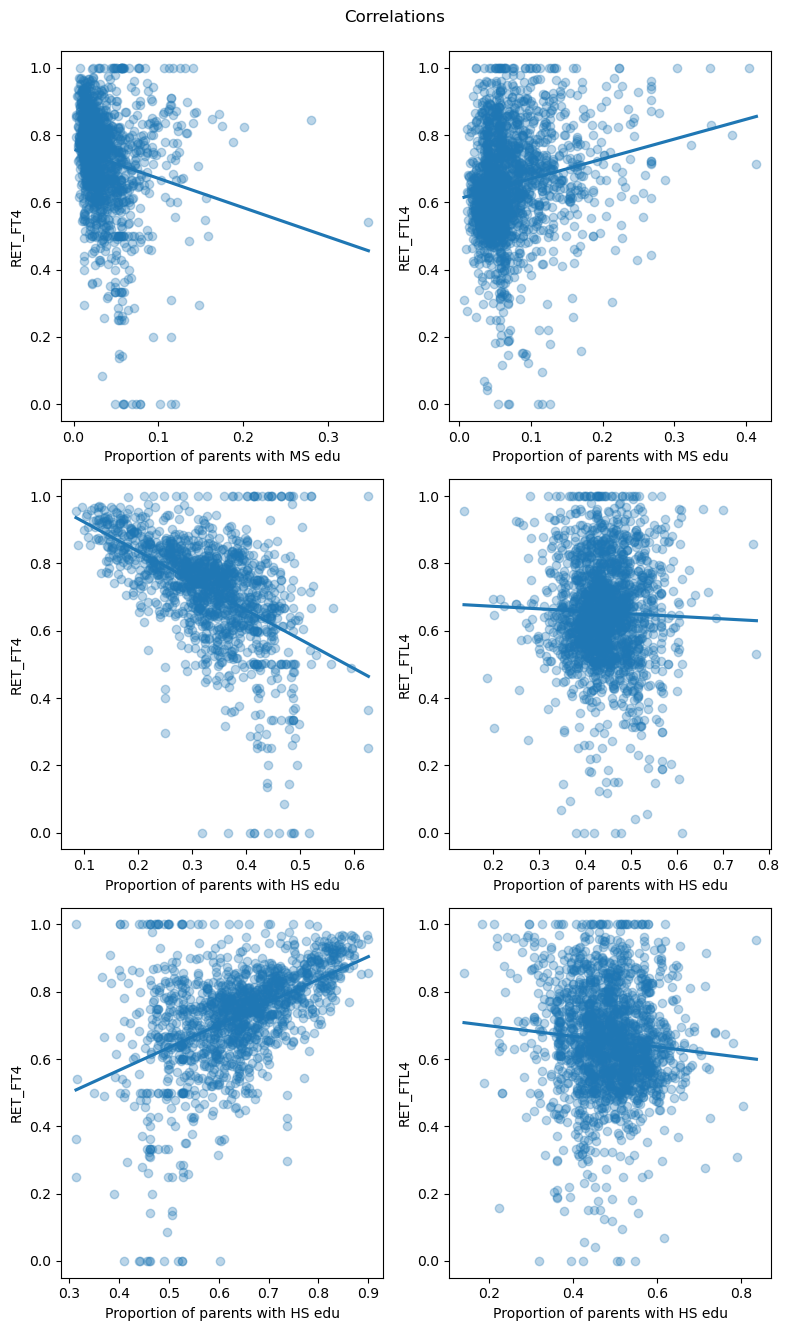

In [476]:
fig, axs = plt.subplots(3, 2, figsize=(8, 13))
sns.regplot(x = "PAR_ED_PCT_MS", y = "RET_FT4", data = edu_no_PrivacySuppressed_ft4, scatter_kws={'alpha':0.3}, ci=False, ax=axs[0,0])
axs[0,0].set_xlabel("Proportion of parents with MS edu")
pos = axs[0,0].get_position()
pos.y0 += .4
axs[0, 0].set_position(pos)
sns.regplot(x = "PAR_ED_PCT_MS", y = "RET_FTL4", data = edu_no_PrivacySuppressed_ftl4, scatter_kws={'alpha':0.3}, ci=False, ax=axs[0,1])
axs[0,1].set_xlabel("Proportion of parents with MS edu")
pos = axs[0,1].get_position()
pos.y0 += .4
axs[0, 1].set_position(pos)
sns.regplot(x = "PAR_ED_PCT_HS", y = "RET_FT4", data = edu_no_PrivacySuppressed_ft4, scatter_kws={'alpha':0.3}, ci=False, ax=axs[1,0])
axs[1,0].set_xlabel("Proportion of parents with HS edu")
sns.regplot(x = "PAR_ED_PCT_HS", y = "RET_FTL4", data = edu_no_PrivacySuppressed_ftl4, scatter_kws={'alpha':0.3}, ci=False, ax=axs[1,1])
axs[1,1].set_xlabel("Proportion of parents with HS edu")
sns.regplot(x = "PAR_ED_PCT_PS", y = "RET_FT4", data = edu_no_PrivacySuppressed_ft4, scatter_kws={'alpha':0.3}, ci=False, ax=axs[2,0])
axs[2,0].set_xlabel("Proportion of parents with college edu")
sns.regplot(x = "PAR_ED_PCT_PS", y = "RET_FTL4", data = edu_no_PrivacySuppressed_ftl4, scatter_kws={'alpha':0.3}, ci=False, ax=axs[2,1])
axs[2,1].set_xlabel("Proportion of parents with college edu")
fig.subplots_adjust(hspace=.2)
fig.tight_layout()
fig.suptitle("Correlations", y= 1.02);


Here we see that parents' middle school education seems have a nonlinear weak relationship with student retention. Parents' highschool and college education seem to be very weakly correlated with retention at less than 4 year institutions.

However, Parents' highschool and college education seems to be strongly correlated with a clear linear relationship with retention at 4 year institutions. Highschool education appears to have a negative correlation while college education has a positive correlationship. This may be because of confounding factors, but the association is clear.

Based on this, we should include parent HS and college education ```PAR_ED_PCT_HS``` and ```PAR_ED_PCT_PS``` in our final analysis.

This approach forces us to remove lots of the data. Instead, we can remove all indices with PrivacySuppressed or nulls for each combination of parent education (```PAR_ED_PCT_MS```, ```PAR_ED_PCT_HS```, ```PAR_ED_PCT_PS```) with student retention (```RET_FT4```, ```RET_FTL4```). 

This results in a unique subsample for each combination making their results less comparable, but the samples have more data in them making each test possible more representative of the fully sample.

In [461]:
#select all indices with "PrivacySuppressed" in them for each column individually
edu_indiv_PrivacySuppressed_indices = edu[["PAR_ED_PCT_MS", "PAR_ED_PCT_HS", "PAR_ED_PCT_PS"]].\
    apply(lambda col: col.astype(str).str.match("PrivacySuppressed"))

#remove those indices to get sample for each parent education and student retention feature combo
edu_no_PrivacySuppressed_MS_ft4 = edu[~edu_indiv_PrivacySuppressed_indices.PAR_ED_PCT_MS]\
    [["PAR_ED_PCT_MS", "RET_FT4"]].\
    dropna().\
    astype(float)
edu_no_PrivacySuppressed_HS_ft4 = edu[~edu_indiv_PrivacySuppressed_indices.PAR_ED_PCT_HS]\
    [["PAR_ED_PCT_HS", "RET_FT4"]].\
    dropna().\
    astype(float)
edu_no_PrivacySuppressed_PS_ft4 = edu[~edu_indiv_PrivacySuppressed_indices.PAR_ED_PCT_PS]\
    [["PAR_ED_PCT_PS", "RET_FT4"]].\
    dropna().\
    astype(float)
edu_no_PrivacySuppressed_MS_ftl4 = edu[~edu_indiv_PrivacySuppressed_indices.PAR_ED_PCT_MS]\
    [["PAR_ED_PCT_MS", "RET_FTL4"]].\
    dropna().\
    astype(float)
edu_no_PrivacySuppressed_HS_ftl4 = edu[~edu_indiv_PrivacySuppressed_indices.PAR_ED_PCT_HS]\
    [["PAR_ED_PCT_HS", "RET_FTL4"]].\
    dropna().\
    astype(float)
edu_no_PrivacySuppressed_PS_ftl4 = edu[~edu_indiv_PrivacySuppressed_indices.PAR_ED_PCT_PS]\
    [["PAR_ED_PCT_PS", "RET_FTL4"]].\
    dropna().\
    astype(float)

#check how large our samples are (note that they are larger)
len(edu_no_PrivacySuppressed_PS_ftl4)

2538

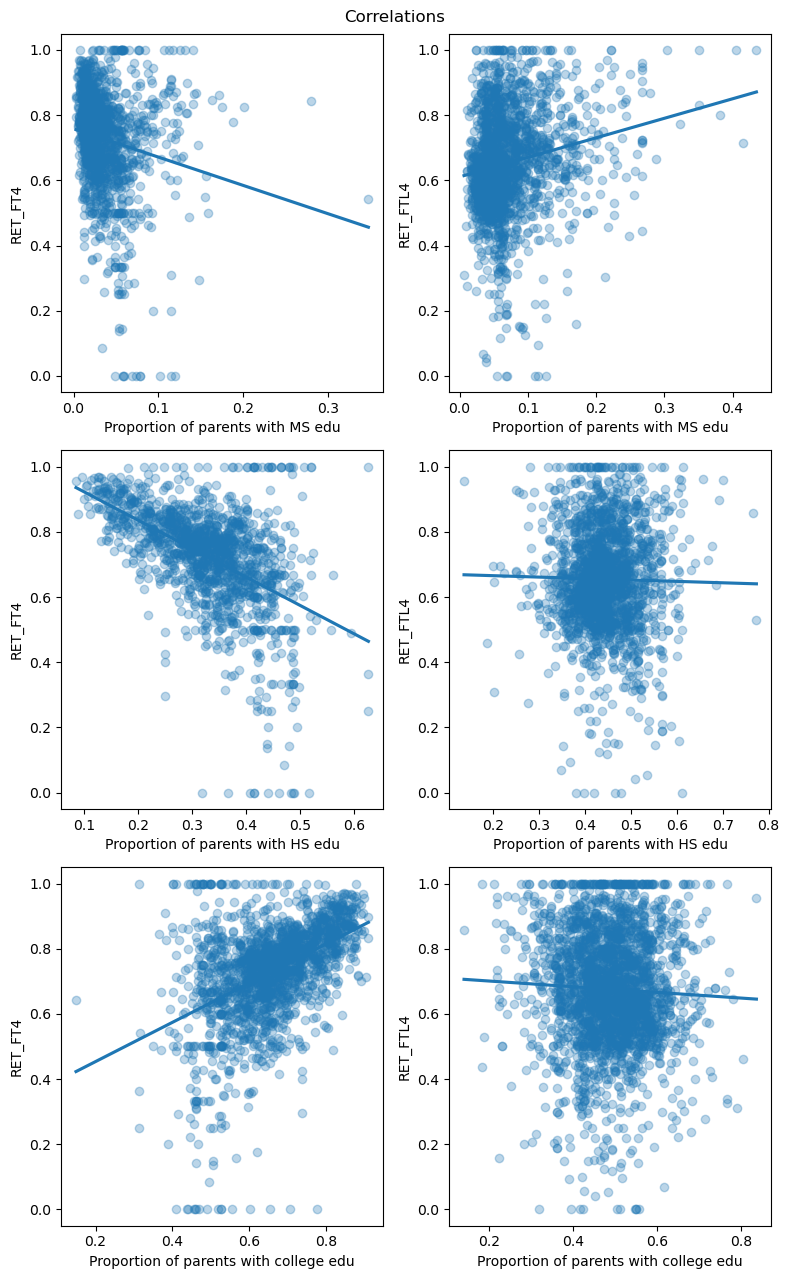

In [462]:
fig, axs = plt.subplots(3, 2, figsize=(8, 13))
sns.regplot(x = "PAR_ED_PCT_MS", y = "RET_FT4", data = edu_no_PrivacySuppressed_MS_ft4, scatter_kws={'alpha':0.3}, ci=False, ax=axs[0,0])
axs[0,0].set_xlabel("Proportion of parents with MS edu")
pos = axs[0,0].get_position()
pos.y0 += .25
axs[0, 0].set_position(pos)
sns.regplot(x = "PAR_ED_PCT_MS", y = "RET_FTL4", data = edu_no_PrivacySuppressed_MS_ftl4, scatter_kws={'alpha':0.3}, ci=False, ax=axs[0,1])
axs[0,1].set_xlabel("Proportion of parents with MS edu")
pos = axs[0,1].get_position()
pos.y0 += .25
axs[0, 1].set_position(pos)
sns.regplot(x = "PAR_ED_PCT_HS", y = "RET_FT4", data = edu_no_PrivacySuppressed_HS_ft4, scatter_kws={'alpha':0.3}, ci=False, ax=axs[1,0])
axs[1,0].set_xlabel("Proportion of parents with HS edu")
sns.regplot(x = "PAR_ED_PCT_HS", y = "RET_FTL4", data = edu_no_PrivacySuppressed_HS_ftl4, scatter_kws={'alpha':0.3}, ci=False, ax=axs[1,1])
axs[1,1].set_xlabel("Proportion of parents with HS edu")
sns.regplot(x = "PAR_ED_PCT_PS", y = "RET_FT4", data = edu_no_PrivacySuppressed_PS_ft4, scatter_kws={'alpha':0.3}, ci=False, ax=axs[2,0])
axs[2,0].set_xlabel("Proportion of parents with college edu")
sns.regplot(x = "PAR_ED_PCT_PS", y = "RET_FTL4", data = edu_no_PrivacySuppressed_PS_ftl4, scatter_kws={'alpha':0.3}, ci=False, ax=axs[2,1])
axs[2,1].set_xlabel("Proportion of parents with college edu")
fig.tight_layout()
fig.suptitle("Correlations");

We get roughly the same results as with the previous method, with parents' college education being strongly positively correlated with retention at 4 year institutions and parents' highscholl education being negatively correlated. This affirms that we should be using these variables in our final analysis of student retention.

790